**TP Filtre de Kalman**

L'objectif de ce TP est la mise en place d'un système d'assimilation de données par filtre de Kalman, pour l'équation des ondes 1D :

$$
\displaystyle{\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}=0}
$$ 

avec les conditions aux limites de Dirichlet homogène.

On propose d'utilsier le $\theta$-schéma, ce qui conduit au schéma à deux niveaux suivant :

$$
\left[ \begin{array}{l} U^{n+1}\\ U^n\end{array}\right]=\left[ \begin{array}{ll} B^{-1}A&-I\\ I&0\end{array}\right]\left[ \begin{array}{l} U^{n}\\ U^{n-1}\end{array}\right] \quad \text{ et }  \quad  U^1=U^0
$$

avec les matrices $A$ et $B$ definies par $A=c^2 \text{Tridiag}([1-2\theta,2/c^2-2+4\theta,1-2\theta])$ et $B=c^2 \text{Tridiag}([\theta,1/c^2+2\theta,-\theta])$.

On suppose disposer d'observations de certaines composantes de la solution $u$ à différents instants selon le modèle

$$
y_n=\mathcal{H}(U^{n})+\epsilon^o_n, \quad \text{ avec } \quad \epsilon^o_n \sim \mathcal{N}(0, R).
$$

Les matrices de covariance d'erreur d'ébauche $P_0$ (associée à U^0), d'observation $R$ et de modèle $Q$ seront suposées des multiples de l'identité. On s'intéressera également à l'impact sur la qualité de prédiction des variances de ces erreurs.

*Sources*: ce TP s'inspire des notebooks d'E. Cosme (UGA) et codes Matlab de S. Gratton (Toulouse INP).


In [1]:
import numpy as np
import math
import scipy as scp
import scipy.sparse as scps
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#-------------------------------------------------------
# Onde 1D
#-------------------------------------------------------

class wave1D:

    def __init__( self, t_init = 0, t_stop = 2500, sigbq=[1.,1.],assim_mode='T'):
        self.t_init = t_init
        self.t_stop = t_stop
        # Mode ébauche/assimilation ou référence
        self.assim_mode=assim_mode
        
        # paramètres de la grille
        self.L=1.0
        self.nx = 500
        self.dt = 0.0001
        self.dx=self.L/(self.nx-1)
        self.n=len(np.arange(0,self.L,self.dx))
        
        # schéma numérique : théta schéma
        self.theta=0.5
        
        # schéma numérique : paramètre de A et B 
        c=self.dt/self.dx
        self.triA=[c**2*(1-2*self.theta), 2-2*c**2+4*c**2*self.theta, c**2*(1-2*self.theta)]
        self.triB=[-c**2*self.theta,1+2*c**2*self.theta,-c**2*self.theta]
        
        # Variance des erreurs d'ébauche et de modèle
        self.sigb=sigbq[0]
        self.sigq=sigbq[1]
        
        # Conditions initiales : x, P0, Q
        self.xvar,self.Pf,self.Q = self.initial_condition()
        
        # Evolution de x et Pf : stockage pour diagnostics
        self.xvar_series = np.zeros((self.nx,t_stop-t_init+1))
        self.Pf_series=np.zeros((self.nx,self.nx,t_stop-t_init+1)) 
        self.time = 0.
        self.time_series = np.zeros((t_stop-t_init+1,)).astype(int)
        
    def initial_condition(self):
        """Conditions initiales : calcul de x0/xb,P0,Q"""
        xout = np.zeros((2*self.nx,))
        ii=np.arange(round(4.5*self.n/10),round(5.5*self.n/10),1)
        xdeb= round(4.5*self.n/10)*self.dx
        xfin=round(5.5*self.n/10)*self.dx

        if (self.assim_mode=='T'):
            # ébauche 
            for k in ii:
                xout[k]=(1-math.sin((k*self.dx-xdeb)*math.pi*20))
            xout[self.nx:]=xout[0:self.nx]
        else:
            # solution de référence : 
            for k in ii:
                xout[k]=(1-math.cos((k*self.dx-xdeb)*math.pi*20))
            xout[self.nx:]=xout[0:self.nx]
        
        # calcul de pout, qout et bruitage de l'ébauche 
        pout = self.sigb*np.kron(np.ones((2,2)),np.eye(self.nx))
        qout = self.sigq*math.sqrt(self.dt)*np.eye(N=self.nx)
        if (self.assim_mode=='T'):
            for k in ii:
                xout[k]=(1-math.sin((k*self.dx-xdeb)*math.pi*20))
            xout[0:self.nx]+= np.random.multivariate_normal(np.zeros(self.nx),pout[0:self.nx,0:self.nx])
            xout[self.nx:]=xout[0:self.nx]
            
        return xout,pout,qout
    
    
    def time_step(self, x_in, t_in):    
        """Evolution temporelle sur un pas de temps"""
        
        x_out = np.zeros_like(x_in)
        
        #Construction des matrices A et B
        data=np.array([self.triA[0]*np.ones((self.nx,)),self.triA[1]*np.ones((self.nx,)),self.triA[2]*np.ones((self.nx,)) ])
        diags=np.array([-1,0,1])
        A=scps.spdiags(data,diags,self.nx,self.nx)
        data=np.array([self.triB[0]*np.ones((self.nx,)),self.triB[1]*np.ones((self.nx,)),self.triB[2]*np.ones((self.nx,)) ])
        diags=np.array([-1,0,1])
        B=scps.spdiags(data,diags,self.nx,self.nx)
        
        # Calcul de x
        x_out[0:self.nx]=sla.spsolve(B,A*x_in[0:self.nx])-x_in[self.nx:]
        x_out[self.nx:]=x_in[0:self.nx]
        
        # Ajout de l'erreur modèle pour la solution de référence
        if self.assim_mode != 'T':
                x_out[0:self.nx] += np.random.multivariate_normal(np.zeros(self.nx), self.Q) 
        
        # Sauvegarde de la date
        self.time = t_in

        return x_out
    
    def forecast(self, t_start = None, t_end = None):
        """Prévision entre deux instants""" 
        """Evolution de l'état et de la matrice de covariance d'erreur de prévision"""
        
        # Initialisation
        if t_start == None or t_end == None:
            t_start = self.t_init
            t_end = self.t_stop
        nstep = t_end - t_start
       
        # Boucle d'évolution de t_start à t_end
        for day in range(t_start, t_end):
            iday = day - self.t_init
            if iday < 0:
                print('Inconsistence entre les temps de début et de fin de la fenêtre')
            
            ## Prévision du vecteur d'état
            self.xvar = self.time_step(self.xvar, day)
            
            #stockage du vecteur d'état
            self.xvar_series[:,iday] = self.xvar[0:self.nx]
            self.time_series[iday] = self.time
       
            ## Prévision de la matrice de covariance d'erreur
            ## Uniquement en mode assimilation
            if self.assim_mode == 'T':
                ### Décomposition racine carré
                U, s, V = np.linalg.svd(self.Pf)
                S = np.diag(np.sqrt(s))
                smat=np.inner(U,S)
                ### Propagation des colonnes au cours du ttemps
                for ix in range(self.nx):
                    smat[:, ix] = self.time_step(smat[:,ix], day)
                ### Assemblage de Pf    
                self.Pf = np.dot(smat, smat.T) 
                self.Pf[0:self.nx,0:self.nx]+=self.Q
                self.Pf_series[:, :, iday] = self.Pf[0:self.nx,0:self.nx]
    
    def plot(self,it):
        plt.figure(figsize=(12,8))
        plt.plot(self.xvar_series[:,it],'black',linewidth=1.)
        plt.show()



/home/felix/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


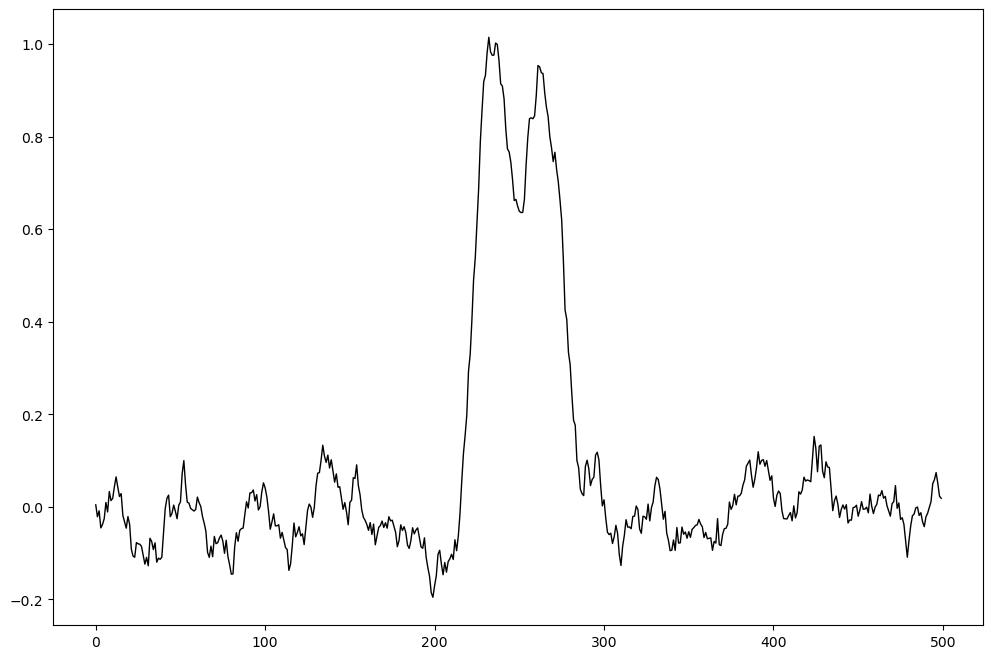

In [3]:
t_start, t_end = 0, 300
ntime = t_end -t_start

# Evolution de la solution de référence
W1D_ref=wave1D(t_init = t_start, t_stop = t_end, sigbq=[1e-6,1e-6],assim_mode='F')
W1D_ref.forecast()
W1D_ref.plot(it=t_end-1)

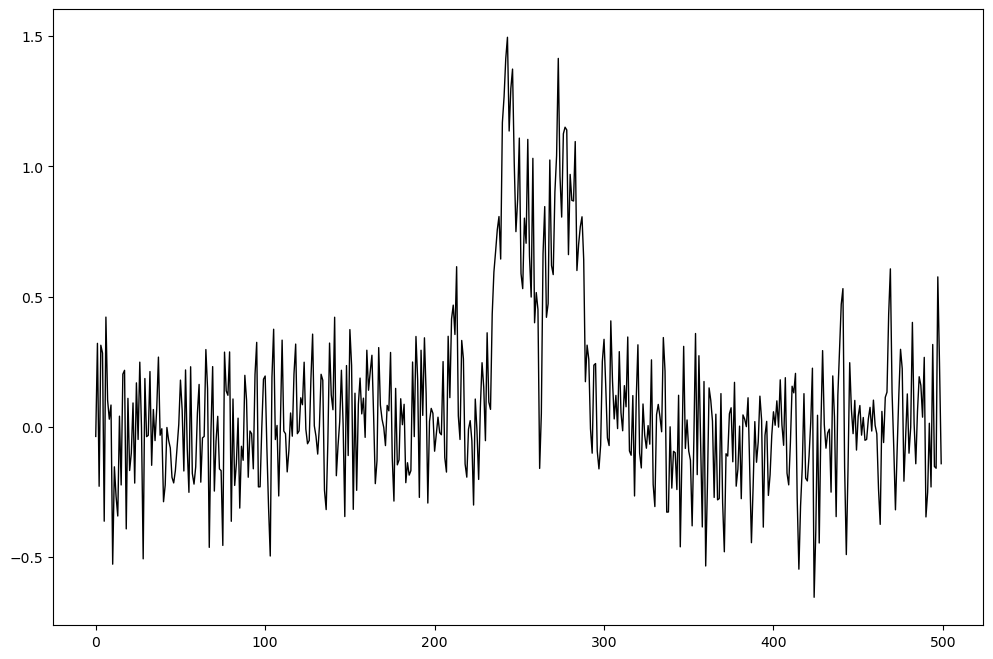

In [4]:
# Evolution de l'ébauche
W1D_bkg=wave1D(t_init = t_start, t_stop = t_end, sigbq=[1e-1,1e-6],assim_mode='T')
W1D_bkg.forecast()
W1D_bkg.plot(it=t_end-1)

In [5]:

# Construction de l'opérateur d'observation H
# On suppose que l'on observe directement, et de manière régulière la référence à instant donné
## TO DO ##
def H_operator(nx):
    H = np.eye(2*nx)  # Crée une matrice identité de taille (2nx, 2nx)
    H = H[nx:, :]     # Retient uniquement les dernières nx lignes
    return H

## Fin TO DO ##

# Localisation temporelle des étapes analyse
# On suppose des fenêtres de prévision de mêmes durées
# On commencera la phase d'assimilation à partir de 100 pas de temps
## TO DO ##
def locate_analysis_steps(start_time, end_time, nb_obs):
    """
    Localisation temporelle des étapes d'analyse.
    
    Paramètres :
        start_time (int) : Temps de début de la phase d'assimilation (en pas de temps).
        end_time (int) : Temps de fin de la phase d'assimilation (en pas de temps).
        nb_obs (int) : Nombre d'observations à réaliser.
    
    Retour :
        analysis_steps (list) : Liste des indices temporels où se produisent les analyses.
    """
    # Calcul des pas
    step = (end_time - start_time) // nb_obs
    analysis_steps = []
    for i in range(start_time, end_time, step):
        analysis_steps.append((i, i+step))
    return analysis_steps


## Fin TO DO ##


In [6]:
# Analyse BLUE
# Analyse BLUE
def analysis(xf, Pf, yobs, Robs, Hobs):
    """
    Calcul de l'analyse avec BLUE.
    
    Paramètres :
        xf (np.ndarray) : État prévision (forecast state), vecteur de taille (n,).
        Pf (np.ndarray) : Matrice de covariance de prévision (forecast covariance), taille (n, n).
        yobs (np.ndarray) : Vecteur des observations, taille (m,).
        Robs (np.ndarray) : Matrice de covariance des erreurs d'observation, taille (m, m).
        Hobs (np.ndarray) : Opérateur d'observation, taille (m, n).
        
    Retour :
        xa (np.ndarray) : État analysé (analysed state), vecteur de taille (n,).
        Pa (np.ndarray) : Matrice de covariance de l'analyse, taille (n, n).
    """
    # Innovation : différence entre observations et prévisions projetées
    innovation = yobs - Hobs @ xf
    
    # Gain de Kalman
    K = Pf @ Hobs.T @ np.linalg.inv(Hobs @ Pf @ Hobs.T + Robs)
    
    # Analyse de l'état
    xa = xf + K @ innovation
    
    # Analyse de la covariance
    I = np.eye(Pf.shape[0])  # Matrice identité
    Pa = (I - K @ Hobs) @ Pf
    
    return xa, Pa

In [7]:
from tqdm import tqdm

In [13]:
# Simulation avec assimilation de données par filtrage de Kalman
W1D_KF = wave1D(t_init = t_start, t_stop = t_end,sigbq=[1e-1,1e-6],assim_mode='T')

# Boucle d'évolution de tstart à tend
## TO DO ##
nb_obs = 50
time_steps = locate_analysis_steps(100, t_end, nb_obs)
for t0, t1 in tqdm(time_steps):
    # Prévision
    W1D_KF.forecast(t0, t1)
    
    # Observations
    Hobs = H_operator(W1D_KF.nx)
    yobs = Hobs @ W1D_ref.xvar_series[:,t1-1]
    Robs = 1e-6 * np.eye(len(yobs))
    
    # Ajout de bruit aux observations
    yobs += np.random.multivariate_normal(np.zeros(len(yobs)), Robs)
    
    # Analyse
    W1D_KF.xvar, W1D_KF.Pf = analysis(W1D_KF.xvar_series[:, t_end-1], W1D_KF.Pf, yobs, Robs, Hobs)
    
    # Stockage des résultats
    #W1D_KF.xvar_series[:, t_end] = W1D_KF.xvar[:W1D_KF.nx]
    #W1D_KF.Pf_series[:, :, t_end] = W1D_KF.Pf[:W1D_KF.nx, :W1D_KF.nx]
    #W1D_KF.time_series[t_end] = W1D_KF.time

## Fin TO DO ##

## Affichage
W1D_KF.plot(it=t_end-1)


  0%|          | 0/50 [00:06<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 500 is different from 1000)

RMS bkg= 0.30826671045220344 RMS KF= 0.21366683861790137


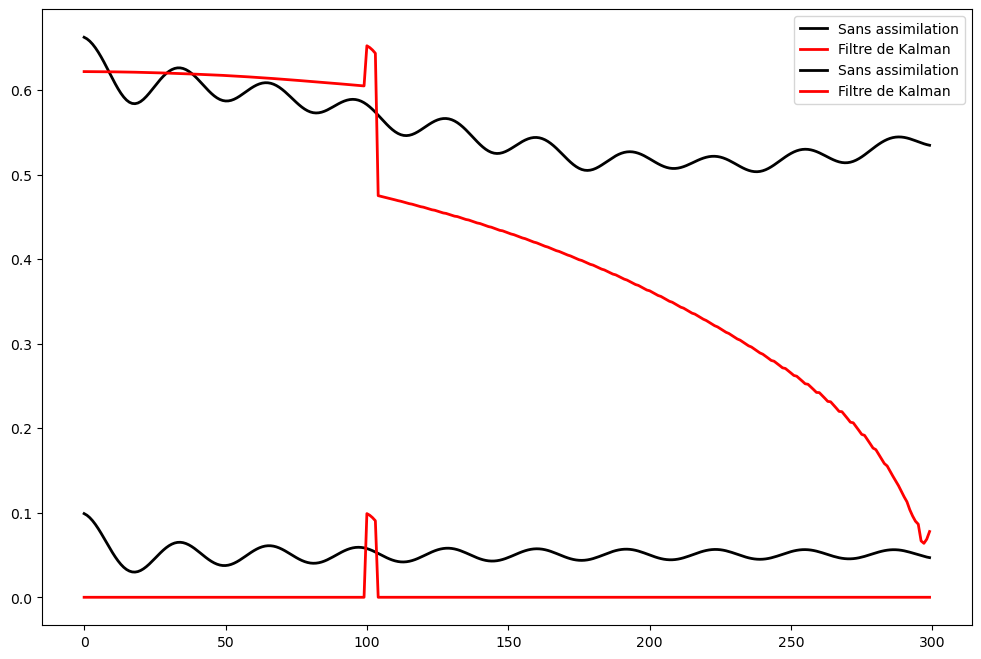

In [ ]:
#Erreur RMS normalisée et trace des matrices de covariance d'erreur

nday=len(W1D_ref.xvar_series[0,:])
RMS_bkg_series=np.zeros((nday-1,))
RMS_bkg=0
VAR_bkg_series=np.zeros((nday-1,))

RMS_KF_series=np.zeros((nday-1,))
RMS_KF=0
VAR_KF_series=np.zeros((nday-1,))

## TO DO ##
for i in range(nday-1):
    RMS_bkg_series[i]=np.sqrt(np.mean((W1D_ref.xvar_series[:,i]-W1D_bkg.xvar_series[:,i])**2))
    VAR_bkg_series[i]=np.mean(np.diag(W1D_bkg.Pf_series[:,:,i]))
    
    RMS_KF_series[i]=np.sqrt(np.mean((W1D_ref.xvar_series[:,i]-W1D_KF.xvar_series[:,i])**2))
    VAR_KF_series[i]=np.mean(np.diag(W1D_KF.Pf_series[:,:,i]))

RMS_bkg=np.mean(RMS_bkg_series)
RMS_KF=np.mean(RMS_KF_series)

RMS_bkg_series=np.sqrt(RMS_bkg_series)
RMS_KF_series=np.sqrt(RMS_KF_series)

bkg_time=W1D_bkg.time_series


## Fin TO DO ##

print('RMS bkg=',RMS_bkg,'RMS KF=',RMS_KF)

plt.figure(figsize=(12,8))
legend=['Sans assimilation','Filtre de Kalman']
plt.subplot()
plt.plot(bkg_time[0:nday-1],RMS_bkg_series[:],'black',label=legend[0], linewidth=2)
plt.plot(bkg_time[0:nday-1],RMS_KF_series[:],'red',label=legend[1],linewidth=2)
plt.legend()
plt.subplot()
plt.plot(bkg_time[0:nday-1],VAR_bkg_series[:],'black',label=legend[0], linewidth=2)
plt.plot(bkg_time[0:nday-1],VAR_KF_series[:],'red',label=legend[1],linewidth=2)
plt.legend()
plt.show()